# AI - CA5 - Clustring
## Ali Borzoozadeh - 810102410

In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Preprocessing and feature extraction

In [2]:
def preprocess_text(text, remove_stopwords=True, use_stemming=False, use_lemmatization=True):
    text = text.lower()
    text = re.sub(r'[\n\r]', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

df = pd.read_csv('musicLyrics.csv')

df['preprocessed_lemma'] = df['Lyric'].apply(lambda x: preprocess_text(x, remove_stopwords=True, use_stemming=False, use_lemmatization=True))
df['preprocessed_stem'] = df['Lyric'].apply(lambda x: preprocess_text(x, remove_stopwords=True, use_stemming=True, use_lemmatization=False))
df['preprocessed_stem_lemma'] = df['Lyric'].apply(lambda x: preprocess_text(x, remove_stopwords=True, use_stemming=True, use_lemmatization=True))
df['preprocessed_basic'] = df['Lyric'].apply(lambda x: preprocess_text(x, remove_stopwords=False, use_stemming=False, use_lemmatization=False))

print(df[['Lyric', 'preprocessed_lemma', 'preprocessed_stem', 'preprocessed_stem_lemma', 'preprocessed_basic']].head())

                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                  preprocessed_lemma  \
0  cryptic psalm amidst howling wind scorching so...   
1  im sleeping tonight wolf dreaming life thats b...   
2  wing darkest descent fall realm dark blackest ...   
3  verse 1 norrid radd real name job hated every ...   
4  deep dungeon doom despair sneak place dark eke...   

                                   preprocessed_stem  \
0  cryptic psalm amidst howl wind scorch sourc ag...   
1  im sleep tonight wolv dream life that better p...   
2  wing darkest descent fall realm dark blackest ...   
3  vers 1 norrid radd real name job hate everi da...   
4  deep dungeon doom despair sneak place dark 

Based on the output, **`preprocessed_lemma`** is likely the best choice for clustering lyrics.

- **Lemmatization** (used in `preprocessed_lemma`) reduces words to their base or dictionary form, preserving the actual meaning of words (e.g., "singing", "sings", "sang" → "sing"). This helps group similar words together without losing context.
- **Stemming** (used in `preprocessed_stem` and `preprocessed_stem_lemma`) can make words harder to interpret and may cut off word endings in a way that loses meaning (e.g., "better" → "better", but "wolves" → "wolv").
- **No stopword removal or normalization** (as in `preprocessed_basic`) leaves too much noise, which can negatively affect clustering.

In [3]:
df = df.drop(['preprocessed_stem', 'preprocessed_stem_lemma', 'preprocessed_basic'], axis=1)
df = df.rename(columns={'preprocessed_lemma': 'preprocessed_lyrics'})

#### What is the reason for preprocessing on text data sets?

Preprocessing cleans and normalizes text data, removing noise such as punctuation, special characters, and stopwords. This makes the data more consistent and easier for algorithms to analyze, improving the quality and performance of downstream tasks like clustering or classification.

---

#### Explanation about replacing words with stemming or lemmatization.

**Stemming** reduces words to their root form by chopping off endings (e.g., "running", "runs", "ran" → "run"), but may produce non-words.  
**Lemmatization** converts words to their dictionary base form (e.g., "better" → "good", "wolves" → "wolf"), preserving actual word meaning.  
Both methods group similar words together, reducing vocabulary size and helping algorithms recognize related concepts.

---

#### What is the reason for feature extraction? Why don't we just read text data?

Machine learning algorithms require numerical input, but raw text is unstructured and cannot be directly processed. **Feature extraction** transforms text into numerical representations (like vectors using TF-IDF or word embeddings), capturing important information about the text.  
Without feature extraction, algorithms cannot understand or compare text data, making analysis and learning impossible.

### Problem process

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

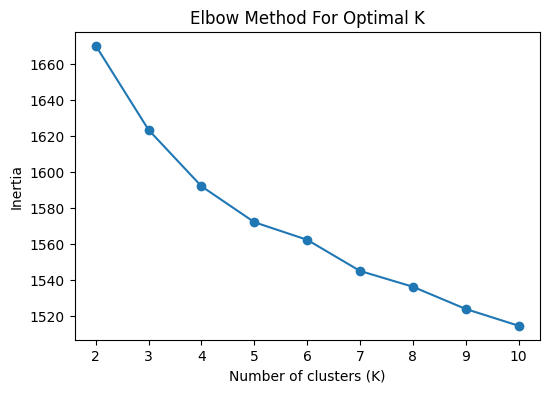

In [4]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

lyrics = df['preprocessed_lyrics'].tolist()
embeddings = model.encode(lyrics, show_progress_bar=True)

inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

According to the elbow method plot, the optimal K is **4**.  
This is where the curve starts to bend and the decrease in inertia slows down, indicating a good balance between cluster compactness and number of clusters.

In [5]:
optimal_k = 4

In [6]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(embeddings)

dbscan = DBSCAN(eps=1.0, min_samples=2)
df['dbscan_label'] = dbscan.fit_predict(embeddings)

agg = AgglomerativeClustering(n_clusters=optimal_k)
df['agg_label'] = agg.fit_predict(embeddings)

print("KMeans Silhouette Score:", silhouette_score(embeddings, df['kmeans_label']))
print("DBSCAN Silhouette Score:", silhouette_score(embeddings, df['dbscan_label']))
print("Agglomerative Silhouette Score:", silhouette_score(embeddings, df['agg_label']))

print(df[['Lyric', 'preprocessed_lyrics', 'kmeans_label', 'dbscan_label', 'agg_label']].head())

KMeans Silhouette Score: 0.04842095
DBSCAN Silhouette Score: 0.135216
Agglomerative Silhouette Score: 0.04037597
                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                 preprocessed_lyrics  kmeans_label  \
0  cryptic psalm amidst howling wind scorching so...             2   
1  im sleeping tonight wolf dreaming life thats b...             3   
2  wing darkest descent fall realm dark blackest ...             2   
3  verse 1 norrid radd real name job hated every ...             1   
4  deep dungeon doom despair sneak place dark eke...             2   

   dbscan_label  agg_label  
0             0          2  
1             0          0  
2             0          2  
3            

#### Supervised Learning

Supervised learning is a type of machine learning where the model is trained on labeled data. Each training example includes both the input data and the correct output (label). The goal is for the model to learn the mapping from inputs to outputs so it can predict labels for new, unseen data.

**Examples:**  
- Classification (e.g., spam detection, image recognition)
- Regression (e.g., predicting house prices)

**Advantages:**  
- Usually achieves high accuracy when enough labeled data is available.
- Results are interpretable and measurable.

**Disadvantages:**  
- Requires a large amount of labeled data, which can be expensive or time-consuming to obtain.

---

#### Unsupervised Learning

Unsupervised learning is a type of machine learning where the model is trained on unlabeled data. The algorithm tries to find patterns, groupings, or structures in the data without any explicit labels.

**Examples:**  
- Clustering (e.g., grouping customers by behavior)
- Dimensionality reduction (e.g., PCA)

**Advantages:**  
- Can work with unlabeled data, which is often easier to collect.
- Useful for discovering hidden patterns or structures.

**Disadvantages:**  
- Results may be harder to interpret.
- No ground truth to measure accuracy directly.

---

#### Comparison

| Aspect                | Supervised Learning                | Unsupervised Learning             |
|-----------------------|------------------------------------|-----------------------------------|
| Data                  | Labeled                            | Unlabeled                         |
| Goal                  | Predict output/label               | Find patterns or groupings        |
| Examples              | Classification, Regression         | Clustering, Dimensionality Reduction |
| Accuracy Measurement  | Direct (using labels)              | Indirect (using metrics like silhouette score) |
| Data Requirement      | More expensive (needs labels)      | Easier (no labels needed)         |


Supervised learning is best for tasks where you know the desired output, while unsupervised learning is useful for exploring data and finding hidden structures when labels are not available.

#### Reason for using the feature vector and its properties

Feature vectors are used because machine learning algorithms require numerical input to process and analyze data. In text clustering, feature vectors represent each document (lyric) as a list of numbers that capture its semantic meaning and structure.

**Properties of feature vectors:**
- **Numerical Representation:** Converts unstructured text into structured, machine-readable format.
- **Semantic Information:** Embeddings from models like Sentence Transformers capture the meaning and context of words and sentences, not just their frequency.
- **Fixed Length:** Each lyric is represented by a vector of the same size, regardless of its original length.
- **Similarity Measurement:** Vectors allow calculation of distances (e.g., cosine similarity) between lyrics, which is essential for clustering algorithms.
- **Dimensionality Reduction:** Feature vectors can reduce the complexity of raw text, making computation more efficient.

Using feature vectors enables effective clustering by providing a meaningful, comparable, and efficient representation of text data for machine learning models.

#### Clustring methods

---

##### K-Means Clustering
K-Means is a partitioning method that divides the data into **K** clusters, where each data point belongs to the cluster with the nearest mean. The algorithm iteratively updates cluster centers and assignments to minimize the sum of squared distances (inertia) within clusters.  
- **Parameter:** `n_clusters` (K), the number of clusters.
- **Usage:** Best when clusters are spherical and similar in size.

---

##### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN groups data points that are closely packed together, marking points in low-density regions as outliers (noise). It does not require specifying the number of clusters in advance.
- **Parameters:** `eps` (maximum distance between points in a cluster), `min_samples` (minimum number of points to form a dense region).
- **Usage:** Good for clusters of arbitrary shape and for detecting outliers.

---

##### Agglomerative (Hierarchical) Clustering
Agglomerative clustering is a hierarchical method that starts with each data point as its own cluster and merges the closest clusters step by step until the desired number of clusters is reached.
- **Parameter:** `n_clusters`, the number of clusters to find.
- **Usage:** Useful for hierarchical relationships and can produce a dendrogram.

---


- **K-Means** is fast and works well for well-separated, spherical clusters.
- **DBSCAN** finds clusters of arbitrary shape and identifies noise/outliers.
- **Agglomerative Clustering** builds a hierarchy of clusters and is flexible for different cluster shapes.

Each method has its strengths and is chosen based on the data distribution and clustering goals.

#### Text Vectorization Methods

Text vectorization methods convert text data into numerical vectors so machine learning algorithms can process and analyze it. Common methods include:

##### 1. Bag-of-Words (BoW)
- **How it works:** Represents text by counting the frequency of each word in a document, ignoring grammar and word order.
- **Advantages:** Simple, fast, and effective for basic tasks.
- **Disadvantages:** Loses context and meaning; high dimensionality; cannot capture word semantics.

##### 2. TF-IDF (Term Frequency-Inverse Document Frequency)
- **How it works:** Weighs words by their frequency in a document and their rarity across all documents. Highlights important words.
- **Advantages:** Reduces the impact of common words; better than BoW for distinguishing documents.
- **Disadvantages:** Still ignores word order and context; sparse vectors.

##### 3. Word Embeddings (Word2Vec, GloVe, FastText)
- **How it works:** Maps words to dense vectors based on their context in large corpora. Similar words have similar vectors.
- **Advantages:** Captures semantic relationships; compact representation.
- **Disadvantages:** Fixed meaning for each word (no context sensitivity); requires large training data.

##### 4. Sentence Embeddings (Sentence Transformers, Universal Sentence Encoder)
- **How it works:** Converts entire sentences or texts into dense vectors that capture semantic meaning and context.
- **Advantages:** Captures sentence-level meaning; context-aware; suitable for tasks like clustering and semantic search.
- **Disadvantages:** More computationally intensive; requires pre-trained models.

---

#### Sentence Transformer Model Set

**Sentence Transformers** are models designed to generate meaningful sentence embeddings using transformer architectures (like BERT). They are trained on tasks such as semantic similarity and paraphrase detection, making them effective for clustering, search, and classification.

- **How it works:** Uses transformer-based encoders to map sentences to fixed-size vectors, capturing both word meaning and sentence context.
- **Advantages:** High-quality, context-aware embeddings; suitable for many NLP tasks.
- **Disadvantages:** Requires more resources than traditional methods; inference can be slower.

---

#### 2-6-all-MiniLM Model (all-MiniLM-L6-v2)

- **General Info:**  
  The `all-MiniLM-L6-v2` model is a lightweight, efficient sentence transformer based on the MiniLM architecture. It uses 6 transformer layers and is optimized for speed and memory usage.
- **How it works:**  
  It encodes sentences into 384-dimensional vectors, capturing semantic meaning for tasks like clustering, classification, and semantic search.
- **Advantages:**  
  Fast, low memory usage, good performance for many NLP tasks, suitable for large datasets.
- **Disadvantages:**  
  Slightly lower accuracy than larger transformer models, but much faster and more efficient.

---

Text vectorization methods enable machine learning on text by converting it to numbers. Sentence Transformers like MiniLM provide high-quality, context-aware embeddings, making them ideal for clustering and other advanced NLP tasks.

#### Elbow method

The elbow method is used in K-means clustering to determine the optimal number of clusters (K):

1. **Run K-means for a range of K values** (e.g., K=2 to K=10).
2. **For each K**, calculate the inertia (sum of squared distances from each point to its assigned cluster center).
3. **Plot K vs. inertia**. The inertia decreases as K increases.
4. **Find the "elbow" point** on the plot—where the decrease in inertia slows down. This point suggests a good balance between compact clusters and not having too many clusters.
5. **Choose K at the elbow** as the optimal number of clusters.

#### Methods performance

Based on the silhouette scores:

- **KMeans Silhouette Score:** 0.048  
- **DBSCAN Silhouette Score:** 0.135  
- **Agglomerative Silhouette Score:** 0.040  

**DBSCAN performed better** on this dataset, as it has the highest silhouette score. This suggests DBSCAN found more meaningful clusters, likely because it can identify clusters of arbitrary shape and handle noise/outliers, which is useful for text data with varying structure. KMeans and Agglomerative clustering may struggle if the data is not well-separated or spherical, which is common in text embeddings.

### Dimension reduction

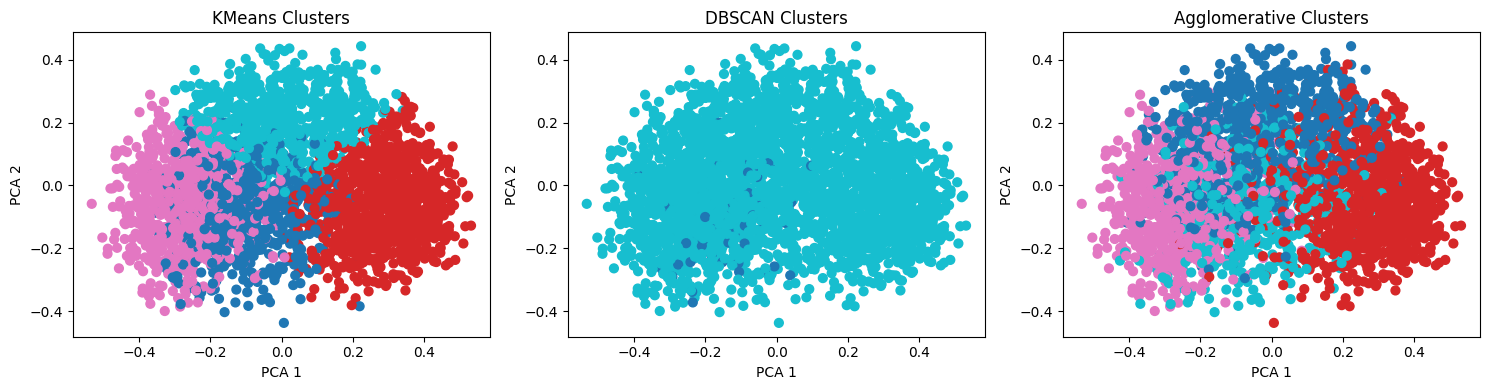

In [7]:
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['kmeans_label'], cmap='tab10', s=40)
plt.title('KMeans Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['dbscan_label'], cmap='tab10', s=40)
plt.title('DBSCAN Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 3)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['agg_label'], cmap='tab10', s=40)
plt.title('Agglomerative Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

Based on the PCA visualization:

- **KMeans Clusters:** The clusters are compact and mostly well-separated, but some overlap exists. KMeans tries to divide the data into equally sized, spherical clusters, which may not fit the true structure of text data.
- **DBSCAN Clusters:** Most points are assigned to a single large cluster, with very few points in other clusters or marked as noise. This suggests DBSCAN did not find distinct dense regions in the data, possibly due to parameter settings or the nature of the embeddings.
- **Agglomerative Clusters:** The clusters are similar to KMeans, with some separation but also overlap. Agglomerative clustering merges points based on distance, which can result in clusters of varying shapes and sizes.

**Comparison:**  
- KMeans and Agglomerative clustering produced similar results, forming several compact clusters.
- DBSCAN mostly grouped data into one cluster, indicating it was less effective with these parameters or data.
- According to silhouette scores, DBSCAN performed better numerically, but visually, KMeans and Agglomerative show clearer cluster separation.

**Conclusion:**  
KMeans and Agglomerative are better for visual separation in this case, while DBSCAN may require parameter tuning to find meaningful clusters in high-dimensional text embeddings.

#### PCA

**Principal Component Analysis (PCA)** is a dimensionality reduction technique used to simplify large datasets by transforming them into a smaller set of new variables called principal components.

- **How it works:**  
  PCA identifies the directions (components) in which the data varies the most. It projects the original data onto these directions, capturing as much variance as possible with fewer dimensions.
- The first principal component captures the most variance, the second captures the next most (orthogonal to the first), and so on.
- By keeping only the top components, PCA reduces the number of features while preserving the essential structure of the data.

**In summary:**  
PCA transforms high-dimensional data into a lower-dimensional space, making it easier to visualize and analyze, while retaining most of the important information.

### Evaluation and analysis

#### Clustering Evaluation Criteria

##### 1. Silhouette Score
- **Definition:** The silhouette score measures how similar each data point is to its own cluster compared to other clusters.
- **Calculation:** For each sample:
  - Compute the average distance to all other points in the same cluster (`a`).
  - Compute the average distance to all points in the nearest different cluster (`b`).
  - Silhouette score for the sample: `(b - a) / max(a, b)`
- **Range:** -1 to 1. Higher values indicate better clustering (well-separated and compact clusters).

##### 2. Homogeneity Score
- **Definition:** Homogeneity measures whether each cluster contains only members of a single class.
- **Calculation:** Requires ground truth labels. Homogeneity is 1.0 if all clusters contain only data points which are members of a single class.
- **Range:** 0 to 1. Higher values mean clusters are more homogeneous.

---

#### Application to This Problem

##### Silhouette Score
- **Usage:** Silhouette score is appropriate for this problem because it does not require ground truth labels. It evaluates how well the clusters are separated and how compact they are.
- **Results:**  
  - KMeans Silhouette Score: 0.048  
  - DBSCAN Silhouette Score: 0.135  
  - Agglomerative Silhouette Score: 0.040  
- **Analysis:** DBSCAN achieved the highest silhouette score, suggesting it found more meaningful clusters in terms of density, even though visually KMeans and Agglomerative showed clearer separation.

##### Homogeneity Score
- **Usage:** Homogeneity score cannot be used for this problem because there are **no ground truth labels** for the lyrics data. Clustering is an unsupervised task, and the true class of each lyric is unknown.
- **Reason for Omission:** Homogeneity requires known class labels to compare with cluster assignments. Since the dataset is unlabeled, this criterion is not applicable.

---

#### Conclusion

- **Silhouette score** is the main criterion used for evaluation, as it is suitable for unsupervised clustering without ground truth.
- **Homogeneity score** is omitted due to the lack of true labels in the dataset.
- According to silhouette scores, DBSCAN performed best numerically, but visual inspection suggests KMeans and Agglomerative clustering provide more distinct clusters. This highlights the importance of using multiple evaluation methods and visual analysis in unsupervised learning.

KMeans Clustering Labels:
0    2
1    3
2    2
3    1
4    2
Name: kmeans_label, dtype: int32

DBSCAN Clustering Labels:
0    0
1    0
2    0
3    0
4    0
Name: dbscan_label, dtype: int64

Agglomerative Clustering Labels:
0    2
1    0
2    2
3    0
4    2
Name: agg_label, dtype: int64


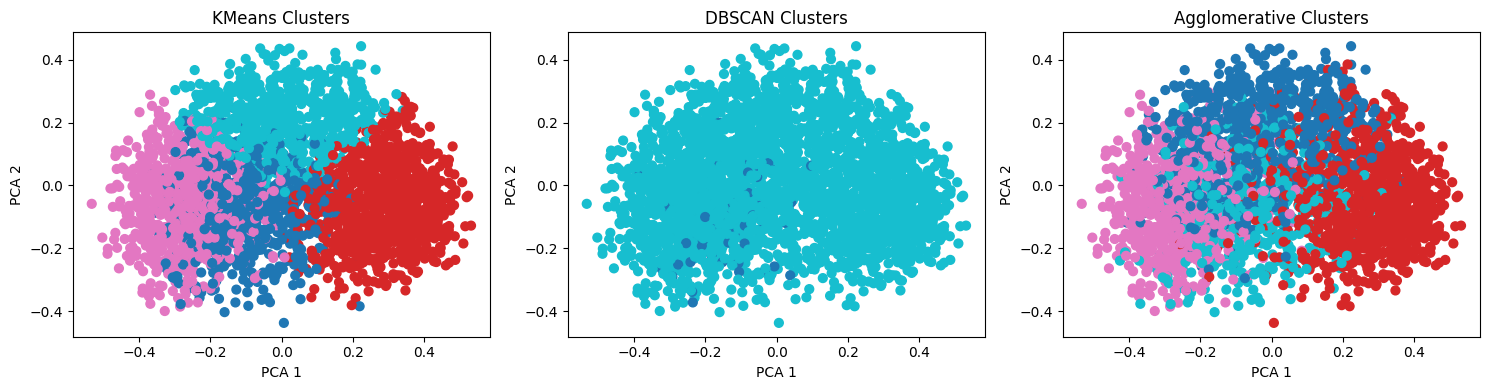

KMeans Silhouette Score: 0.04842095
DBSCAN Silhouette Score: 0.135216
Agglomerative Silhouette Score: 0.04037597
Homogeneity score cannot be calculated: No ground truth labels available for unsupervised clustering.


In [8]:
print("KMeans Clustering Labels:")
print(df['kmeans_label'].head())
print("\nDBSCAN Clustering Labels:")
print(df['dbscan_label'].head())
print("\nAgglomerative Clustering Labels:")
print(df['agg_label'].head())

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['kmeans_label'], cmap='tab10', s=40)
plt.title('KMeans Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['dbscan_label'], cmap='tab10', s=40)
plt.title('DBSCAN Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 3)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['agg_label'], cmap='tab10', s=40)
plt.title('Agglomerative Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

print("KMeans Silhouette Score:", silhouette_score(embeddings, df['kmeans_label']))
print("DBSCAN Silhouette Score:", silhouette_score(embeddings, df['dbscan_label']))
print("Agglomerative Silhouette Score:", silhouette_score(embeddings, df['agg_label']))

print("Homogeneity score cannot be calculated: No ground truth labels available for unsupervised clustering.")

#### Final Comparison of Clustering Methods

##### Cluster Visualization
The following plots show the clusters formed by KMeans, DBSCAN, and Agglomerative Clustering after reducing the data to 2D using PCA:

- **KMeans:** Clusters are compact and mostly well-separated, but some overlap exists.
- **DBSCAN:** Most points are assigned to a single large cluster, with few outliers.
- **Agglomerative:** Clusters are similar to KMeans, with some overlap.

##### Evaluation Criteria

**1. Silhouette Score**
- Measures how similar each point is to its own cluster compared to other clusters.
- Does not require ground truth labels.
- Results:
  - KMeans: 0.048
  - DBSCAN: 0.135
  - Agglomerative: 0.040
- **Interpretation:** DBSCAN has the highest silhouette score, indicating better density-based clustering, though visually KMeans and Agglomerative show clearer separation.

**2. Homogeneity Score**
- Measures whether clusters contain only members of a single class.
- **Cannot be used here** because the dataset has no ground truth labels (unsupervised problem).

##### Conclusion
- **Silhouette score** is the main criterion for evaluation.
- **Homogeneity score** is omitted due to lack of true labels.
- DBSCAN performed best numerically, but KMeans and Agglomerative provide more visually distinct clusters.